In [1]:
import os
import random
from PIL import Image, ImageDraw, ImageFont

import pandas as pd
import numpy as np
from sklearn.utils import shuffle
from datasets import Dataset, Features, Value, ClassLabel, Sequence, Array2D, Array3D
from transformers import AutoProcessor, AutoModelForSequenceClassification, TrainingArguments, Trainer
import torch
import evaluate

RANDOM_STATE = 1992
random.seed(RANDOM_STATE)
TRAIN_DEV_SET_SIZE = 120

os.environ["TOKENIZERS_PARALLELISM"] = "false"

/Users/davidhajdu/Desktop/Projects/DocumentClassifier/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Filter out the train/dev set and create a Pandas DataFrame

In [2]:
def create_dataframe(root_folder):
    data = []
    
    for root, dirs, files in os.walk(root_folder):
        for file in files:
            if file != '.DS_Store':
                target = os.path.basename(root)
                filename = file
                relative_path = os.path.relpath(os.path.join(root_folder, root, file), root_folder)
                data.append((filename, target, relative_path))
    
    df = pd.DataFrame(data, columns=['filename', 'target', 'relative_path'])
    return df

def sample_per_target(df):
    sampled_data = []
    groups = df.groupby('target')
    
    for target, group in groups:
        if len(group) >= TRAIN_DEV_SET_SIZE:
            sampled_data.append(group.sample(n=TRAIN_DEV_SET_SIZE, random_state=RANDOM_STATE))
        else:
            sampled_data.append(group)
    
    sampled_df = pd.concat(sampled_data)
    return sampled_df

In [4]:
df = create_dataframe('docs-sm')

train_df = sample_per_target(df)

train_df = shuffle(train_df)
train_df = train_df.reset_index()

df.to_csv('raw_dataset.csv', index=False)
train_df.to_csv('train_dataset.csv', index=False)

# Collect all labels and create id2label and label2id dicts
labels = list(set(train_df['target'].to_list()))
id2label = {k: v for k,v in enumerate(labels)}
label2id = {v: k for k,v in enumerate(labels)}

train_df['enc_target'] = train_df.target.map(lambda x : label2id[x])
display(train_df)

,index,filename,target,relative_path,enc_target
0,2063,524923780+-3800.jpg,questionnaire,docs-sm/questionnaire/524923780+-3800.jpg,1
1,1506,512560073+-0073.jpg,letter,docs-sm/letter/512560073+-0073.jpg,6
2,3419,500579741.jpg,advertisement,docs-sm/advertisement/500579741.jpg,12
3,2886,2028443192_2028443199.jpg,scientific_publication,docs-sm/scientific_publication/2028443192_2028...,13
4,1263,96184957_4958.jpg,letter,docs-sm/letter/96184957_4958.jpg,6
...,...,...,...,...,...
1915,2554,2505108369.jpg,scientific_report,docs-sm/scientific_report/2505108369.jpg,8
1916,1918,84197670_7678.jpg,questionnaire,docs-sm/questionnaire/84197670_7678.jpg,1
1917,4529,501703529+-3529.jpg,invoice,docs-sm/invoice/501703529+-3529.jpg,0
1918,442,1003537592-a.jpg,news_article,docs-sm/news_article/1003537592-a.jpg,2


In [5]:
train_df['target'].value_counts()

target
questionnaire             120
letter                    120
advertisement             120
scientific_publication    120
news_article              120
scientific_report         120
form                      120
handwritten               120
memo                      120
specification             120
file_folder               120
resume                    120
invoice                   120
budget                    120
email                     120
presentation              120
Name: count, dtype: int64

Selected image class: memo


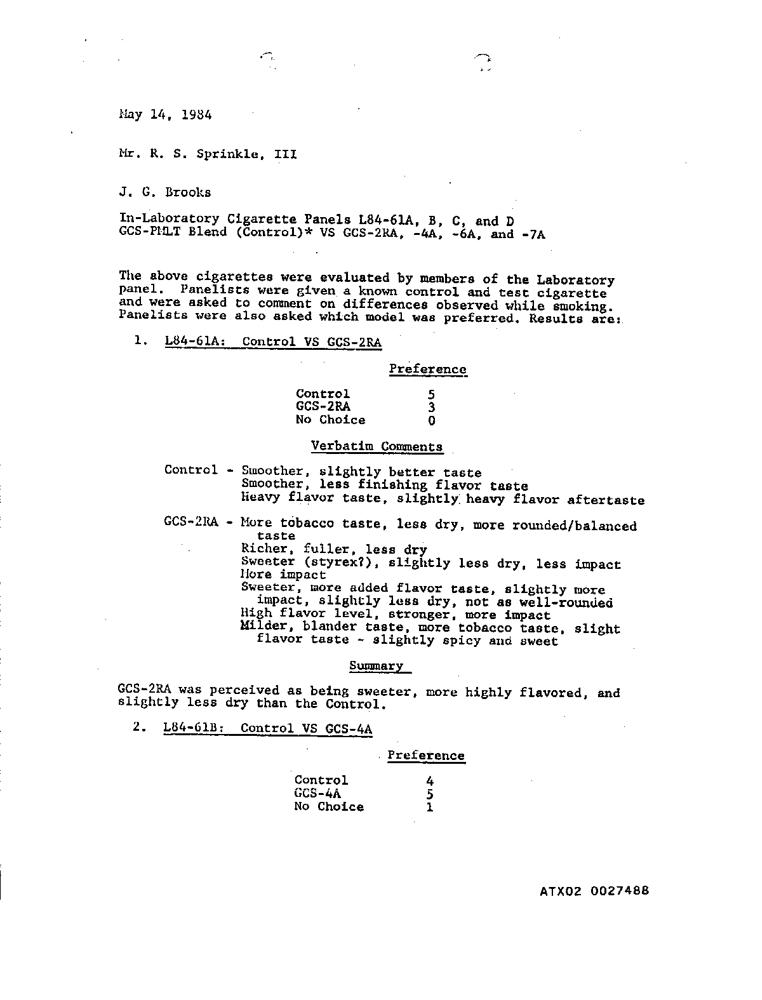

In [6]:
idx = 45
print(f'Selected image class: {train_df.loc[idx, 'target']}')

image = Image.open(train_df.loc[idx, 'relative_path'])
image = image.convert("RGB")
image

In [7]:
raw_dataset = Dataset.from_pandas(train_df, features=Features({'index': Value(dtype='int64', id=None),
                                                                'filename': Value(dtype='string', id=None),
                                                                'target':  ClassLabel(names=labels),
                                                                'relative_path': Value(dtype='string', id=None),
                                                                'enc_target': Value(dtype='int64', id=None)}))

raw_dataset

Dataset({
    features: ['index', 'filename', 'target', 'relative_path', 'enc_target'],
    num_rows: 1920
})

In [8]:
raw_dataset.features

{'index': Value(dtype='int64', id=None),
 'filename': Value(dtype='string', id=None),
 'target': ClassLabel(names=['invoice', 'questionnaire', 'news_article', 'memo', 'resume', 'presentation', 'letter', 'specification', 'scientific_report', 'budget', 'handwritten', 'form', 'advertisement', 'scientific_publication', 'file_folder', 'email'], id=None),
 'relative_path': Value(dtype='string', id=None),
 'enc_target': Value(dtype='int64', id=None)}

### Run OCR on images. Extract HF input meta data. I use LayoutLMv3 processor with OCR (this use pytessaract and extract every meta data directly from the input image)

In [9]:
processor = AutoProcessor.from_pretrained("microsoft/layoutlmv3-base", apply_ocr=True)

In [10]:
encoded_inp = processor(image, return_tensors="pt")

In [11]:
encoded_inp.keys()

dict_keys(['input_ids', 'attention_mask', 'bbox', 'pixel_values'])

In [12]:
len(encoded_inp['input_ids'][0]), len(encoded_inp['attention_mask'][0]), len(encoded_inp['bbox'][0])

(324, 324, 324)

In [13]:
for k,v in encoded_inp.items():
  print(k, v.shape)

input_ids torch.Size([1, 324])
attention_mask torch.Size([1, 324])
bbox torch.Size([1, 324, 4])
pixel_values torch.Size([1, 3, 224, 224])


In [14]:
processor.tokenizer.decode(encoded_inp.input_ids.squeeze().tolist())

'<s> Hay 14, 1984 Mr. R. S. Sprinkle, IIZ a Brooks In-Laboratory Cigarette Panels L84-61A, B, C, and D GCS-PELT Blend (Control)* VS GCS-2RA, “4A; -éa, and -7A The above cigarettes were evaluated by members of the Laboratory Panel. Panelists were given a known control and test cigarette and were asked to comment on differences observed while smoking. Panelists were also asked which model was preferred. Resulte are: 2, L84-61A: Control VS GCS-2RA Preferenc: Control 5 GCS-2RA 3 No Choice 0 Verbatim Comments Control ~ Swoother, slightly better taste Suoother, less finishing flavor taste Heavy flavor taste, slightly. heavy flavor aftertaste GCS-2RA - More tobacco taste, less dry, more rounded/balanced taste Richer, fuller, less dry Sweeter (styrex?), slightly less dry, less impact Hore impact Sweeter, more added flavor taste, slightly more impact, slightly less dry, not’ae well-rounded High flavor level, stronger, more impact Milder, blander taste, more tobacco taste, slight flavor taste ~ 

### Split dataset into train and test split

In [15]:
dataset = raw_dataset.train_test_split(test_size=0.2, stratify_by_column="target")

del raw_dataset

In [16]:
dataset

DatasetDict({
    train: Dataset({
        features: ['index', 'filename', 'target', 'relative_path', 'enc_target'],
        num_rows: 1536
    })
    test: Dataset({
        features: ['index', 'filename', 'target', 'relative_path', 'enc_target'],
        num_rows: 384
    })
})

In [17]:
dataset['train'][0]

{'index': 3457,
 'filename': '509132521+-2521.jpg',
 'target': 12,
 'relative_path': 'docs-sm/advertisement/509132521+-2521.jpg',
 'enc_target': 12}

In [18]:
features = Features({
    'pixel_values': Array3D(dtype="float32", shape=(3, 224, 224)),
    'input_ids': Sequence(feature=Value(dtype='int64')),
    'attention_mask': Sequence(Value(dtype='int64')),
    'bbox': Array2D(dtype="int64", shape=(512, 4)),
    'labels': ClassLabel(num_classes=len(labels), names=labels),
})

def preprocess_data(examples):
  images = [Image.open(path).convert("RGB") for path in examples['relative_path']]
  
  encoded_inputs = processor(images, padding="max_length", truncation=True)
  
  encoded_inputs["labels"] = [label for label in examples["target"]]

  return encoded_inputs

In [ ]:
train_dataset = dataset["train"].map(
    preprocess_data,
    batched=True,
    features=features,
    batch_size=4,
    num_proc=4,
    remove_columns=dataset["train"].column_names
)

In [ ]:
train_dataset.save_to_disk('train_rvl_dcip')

In [22]:
eval_dataset = dataset["test"].map(
    preprocess_data,
    batched=True,
    features=features,
    batch_size=4,
    num_proc=4,
    remove_columns=dataset["test"].column_names
)

Map (num_proc=4): 100%|██████████| 384/384 [10:58<00:00,  1.71s/ examples]


In [23]:
eval_dataset.save_to_disk('eval_rvl_dcip')

Saving the dataset (1/1 shards): 100%|██████████| 384/384 [00:01<00:00, 249.75 examples/s]
